## Trabajo Práctico: Red Neuronal Lineal.

aca hay que poner una introducción supongo idk



Nota: aca en el notebook usamos algunas funciones como @, qr, de NP solo para probar y comparar con
los resultados correctos (calculados con numpy). Las soluciones a todos los sistemas verdaderos y las implementaciones de 
todas las funciones nuestras implementan cada una de estas operaciones a mano. 

Lo que si, usamos las funciones np.sum, np.min, np.max para poder vectorizar cuentas que si no tardaban mucho, 
como prodint() que se usa en nuestra multiplicacion de matrices

In [125]:
import numpy as np
import sys
import matplotlib.pyplot as plt

from alc import *
# TODO esto todo va a estar en alc cuando terminemos y hay que borrarlo
sys.path.append(".")
sys.path.append("./src")
sys.path.append("../src")
from labo00_auxiliares import *
from labo01_errores_igualdad import *
from labo02_TLs_basicas import *
from labo03_normas import *
from labo04_LU import *
from labo05_QR import *
from labo06_AVs import *
from labo07_markov import *
from labo08_SVD import *
import os


np.set_printoptions(precision=3, linewidth=150, suppress=True)

os.getcwd()[-3:]
tol = 0.01



no se explicar que hacemos las pruebas

Recordamos, los "t" son los valores de entrenamiento, y los v son los de testeo

In [126]:
#Xt, Yt, Xv, Yv = cargarDataset("cats_and_dogs") 
Xt, Yt, Xv, Yv =  cargarDatasetReducido("cats_and_dogs", 5, 5)
print(Xt.shape)
print(Xv.shape)
print(Yt[:,:3], Yt.shape)
print(Yt[:,:3], Yv.shape)

(5, 10)
(5, 10)
[[0 0 0]
 [1 1 1]] (2, 10)
[[0 0 0]
 [1 1 1]] (2, 10)


### QR
Tuvimos que cambiar la funcion de QR del labo para que acepte matrices no cuadradas.
  
Queremos no tener que volver a hacer cuentas muy largas mientras testeamos. QR por GS no es lento asi que no es tan necesario, pero lo hacemos empezando aca por consistencia

In [127]:
cache_save_enabled = False
cache_load_enabled = False

def cache(calc, name):
    if cache_load_enabled and os.path.isfile(f"{name}.npy"):
        return np.load(f"{name}.npy")
    else:
        val = calc()
        if cache_save_enabled:
            np.save(f"{name}.npy", val)
        return val

def cache_many(calc, names):
    if cache_load_enabled and all([os.path.isfile(f"{name}.npy") for name in names]):
        return tuple([cache(lambda:None, name) for name in names])
    else:
        vals = calc()
        for name, val in zip(names, vals):
            cache(lambda:val, name)
        return vals
    
# no quiero perder horas de computo pq fallo un assert, armo esto para que si "Fallaría" el assert te avisa
def pseudoAssertEquality(X,Y, atol = tol):
    try:
        assert np.allclose(X,Y, atol=tol)
    except:
        print("ERROR: Necesita tolerancia ", np.max(np.abs(X-Y)))
    

#### Por Gram shmidt

In [128]:
tiempogr = datetime.now()
Q, R = cache_many(lambda: QR_con_GS(traspuesta(Xt)), ["QGS", "RGS"])

WGS = cache(lambda:pinvGramSchmidt(Q,R,Yt), "WGS")

YvProbabilidadesGS = cache(lambda:matmul(WGS, Xv), "YvProbabilidadesGS")



<class 'numpy.ndarray'> <class 'numpy.ndarray'>
listo resolviendo sistema
listo trasponiendo
Calculando W


In [129]:
tiempofinalgr = datetime.now()
print("Tardo:", (tiempofinalgr-tiempogr).seconds, "segundos")

Tardo: 0 segundos


In [130]:

# verificamos que 
pseudoAssertEquality(Q @ R, traspuesta(Xt), atol=tol) # lo hago con @ solo aca para probar

## comparemos con funcion numpy por si a caso
QNP,RNP = np.linalg.qr(traspuesta(Xt))
YvProbabilidadesNPQR = pinvGramSchmidt(QNP,RNP,Yt) @ Xv
pseudoAssertEquality(YvProbabilidadesGS,  YvProbabilidadesNPQR, atol=tol)
difProbabilidadesGR=np.max(np.abs(YvProbabilidadesGS-YvProbabilidadesNPQR))




<class 'numpy.ndarray'> <class 'numpy.ndarray'>
listo resolviendo sistema
listo trasponiendo
Calculando W


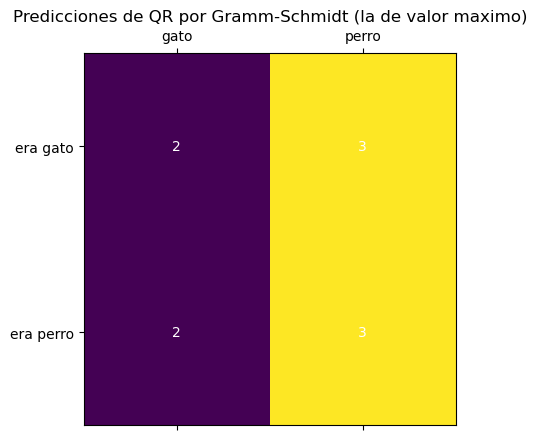

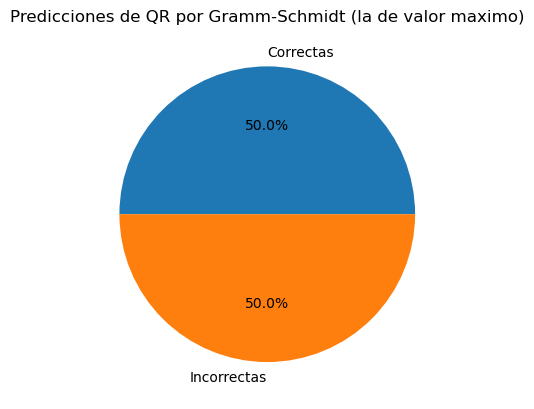

In [131]:
# medio feo tener un choclo de codigo aca pero peor era tener que importar matplotlib en ALC.py  
def graficar_predicciones_de_metodo(nombre_metodo, predicciones, valores_reales):
    gato = [1,0]
    perro = [0,1]


    posibilidadesNombres = ["gato", "perro"]
    confusion2 = np.zeros((2,2))
    for prediccion, valorCorrecto in zip(  traspuesta(predicciones) , traspuesta(valores_reales) ):
        indiceY = int(1-valorCorrecto[0])
        indiceX = int(max(prediccion) == prediccion[1])
        confusion2[ indiceY ][ indiceX ] += 1
    
    plt.matshow(confusion2)
    plt.title(f"Predicciones de {nombre_metodo} (la de valor maximo)")
    plt.xticks(range(len(posibilidadesNombres)), posibilidadesNombres)
    plt.yticks(range(len(posibilidadesNombres)), ["era "+n for n in posibilidadesNombres ])
    
    for i ,row in enumerate(confusion2):
        for j ,val in enumerate(row):
            plt.text(j, i, f"{int(val)}", ha="center", va="center", color="white" if val < 200 else "black") 
    plt.show()
    pie(confusion2, nombre_metodo + " (la de valor maximo)")


def pie(confusion, nombre_metodo):
    correcto = 0
    incorrecto = 0
    for i in range(len(confusion)):
        correcto += confusion[i][i]

    incorrecto = len(Xv[0]) - correcto
    plt.pie([correcto, incorrecto], labels=["Correctas", "Incorrectas"], autopct='%1.1f%%')
    plt.title(f"Predicciones de {nombre_metodo}")
    plt.show()

graficar_predicciones_de_metodo("QR por Gramm-Schmidt", YvEsperadosGS, Yv)


como medida de performance se utilizó la exactitud, la cual se mide como $(TP + TN)/(P + N)$

#### Por HH

In [132]:
tiempohh = datetime.now()

QHH, RHH = cache_many(lambda: QR_con_HH(traspuesta(Xt)), ["QHH", "RHH"])
WHH = cache(lambda:pinvHouseHolder(QHH,RHH,Yt), "WHH")
YvProbabilidadesHH = cache(lambda:matmul(WHH, Xv), "YvProbabilidadesHH")


QHH,RHH = np.linalg.qr(traspuesta(Xt))
YvProbabilidadesNPQR = pinvHouseHolder(QHH,RHH,Yt) @ Xv
pseudoAssertEquality(YvProbabilidadesHH,  YvProbabilidadesNPQR, atol=tol)
difProbabilidadesHH=np.max(np.abs(YvProbabilidadesHH-YvProbabilidadesNPQR))


householderizando 0-esima sumbatriz de 5 a las 13:36:03.045226
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
listo resolviendo sistema
listo trasponiendo
Calculando W
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
listo resolviendo sistema
listo trasponiendo
Calculando W


In [133]:
tiempofinalhh = datetime.now()
print("Tardo:", (tiempofinalhh-tiempohh).seconds, "segundos")

Tardo: 0 segundos


In [134]:

pseudoAssertEquality(WHH, WGS, atol=tol)

pseudoAssertEquality(QHH @ RHH, traspuesta(Xt), atol=tol) # lo hago con @ solo aca para probar mas rapido
print(f"W: {np.round(WHH,3).shape}")
print(YvProbabilidadesHH)
print(Yv)

W: (2, 5)
[[ 0.267  1.569 -0.403  0.518  3.066 -0.31   1.707 -0.077  1.416  0.137]
 [ 1.151  2.32   0.324  0.055  1.237  0.595  0.617  0.06   1.151  0.9  ]]
[[0 0 0 0 0 1 1 1 1 1]
 [1 1 1 1 1 0 0 0 0 0]]


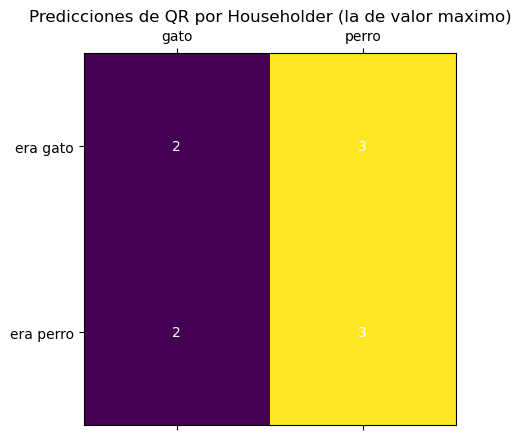

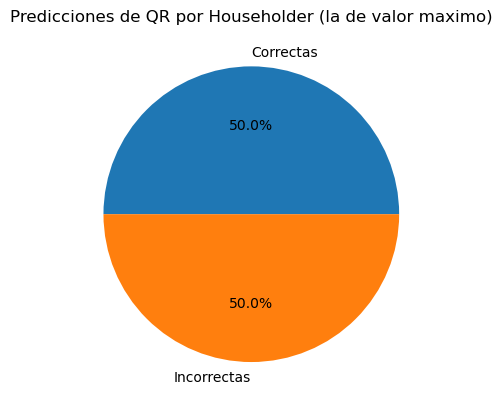

In [135]:
graficar_predicciones_de_metodo("QR por Householder", YvProbabilidadesHH, Yv)


### SVD

In [136]:
tiemposvd = datetime.now()

U,S,V = cache_many(lambda: svd_reducida(Xt, tol=tol), ["U","S","V"])

# svd_reducida, como pide su enunciado, devuelve un vector en S. pero pinvSVD tiene que tomar una matriz. 
# generamos la matriz SM
def diagFrom(list, shape):
    res = np.zeros(shape)
    for i,item in  enumerate(list):
        res[i][i] = item
    return res

 

WSVD = cache(lambda:pinvSVD(U,diagFrom(S, Xt.shape),V,Yt), "WSVD")

YvProbabilidadesSVD = cache(lambda:matmul(WSVD, Xv), "YvProbabilidadesSVD")



In [137]:
tiempofinalsvd = datetime.now()
print("Tardo:", (tiempofinalsvd-tiemposvd).seconds, "segundos")

Tardo: 0 segundos


In [138]:


print(f"W: {np.round(WSVD,3).shape}")
pseudoAssertEquality(U @ np.diag(S) @ traspuesta(V), Xt, atol=tol)

print(YvProbabilidadesSVD)
print(Yv)

# Generamos un SVD usando numpy para comparar que tan diferente queda comparada con la nuestra 
UNP,SNP,VNP = np.linalg.svd(Xt)
VNP = VNP.T[:,:Xt.shape[0]]
pseudoAssertEquality(UNP @ np.diag(SNP) @ traspuesta(VNP), Xt, atol=tol)

WSVDNP = pinvSVD(UNP,diagFrom(SNP, Xt.shape),VNP,Yt)
YvProbabilidadesSVDNP = WSVDNP @ Xv

pseudoAssertEquality(YvProbabilidadesSVD, YvProbabilidadesSVDNP, atol=tol)

difProbabilidadesSVD=np.max(np.abs(YvProbabilidadesSVD-YvProbabilidadesSVDNP))


W: (2, 5)
[[ 0.261  1.582 -0.4    0.502  3.118 -0.301  1.745 -0.07   1.42   0.133]
 [ 1.158  2.317  0.318  0.033  1.256  0.61   0.635  0.06   1.151  0.902]]
[[0 0 0 0 0 1 1 1 1 1]
 [1 1 1 1 1 0 0 0 0 0]]
ERROR: Necesita tolerancia  0.051710180134226125


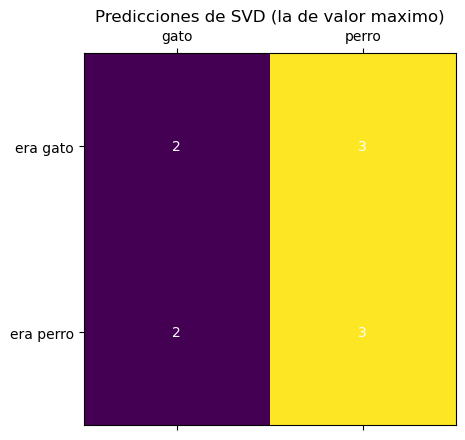

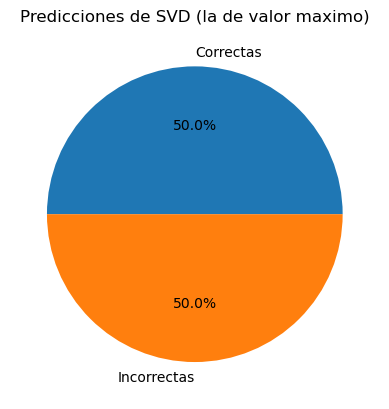

In [139]:
graficar_predicciones_de_metodo("SVD", YvProbabilidadesSVD, Yv)

### Cholesky / Ecuaciones Normales

In [140]:
tiempoch= datetime.now()

LCholesky = cache(lambda: cholesky(matmul(Xt, traspuesta(Xt))), "LCholesky")

WEqNorm = cache(lambda:pinvEcuacionesNormales(Xt,LCholesky,Yt), "WEN")

YvProbabilidadesEqNorm = cache(lambda:matmul(WEqNorm, Xv), "YvProbabilidadesEqNorm")



choleskizando 0-esima columna a las 13:36:03.294083
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [141]:
tiempofinalch = datetime.now()
print("Tardo:", (tiempofinalch-tiempoch).seconds, "segundos")

Tardo: 0 segundos


In [142]:

print(f"W: {np.round(WEqNorm,3).shape}")
pseudoAssertEquality(LCholesky @ traspuesta(LCholesky), matmul(Xt, traspuesta(Xt)), atol=tol)

print(YvProbabilidadesEqNorm)
print(Yv)


LCholeskyNP = np.linalg.cholesky(Xt @ Xt.T)

WWEqNormNP = pinvEcuacionesNormales(Xt, LCholeskyNP, Yt)
YvProbabilidadesEqNormNP = WWEqNormNP @ Xv

# es tan inestable que el psuedoAserteEq puede fallar!

difProbabilidadesEqNorm=np.max(np.abs(YvProbabilidadesEqNorm-YvProbabilidadesEqNormNP))

W: (2, 5)
[[ 0.267  1.569 -0.403  0.518  3.066 -0.31   1.707 -0.077  1.416  0.137]
 [ 1.151  2.32   0.324  0.055  1.237  0.595  0.617  0.06   1.151  0.9  ]]
[[0 0 0 0 0 1 1 1 1 1]
 [1 1 1 1 1 0 0 0 0 0]]
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


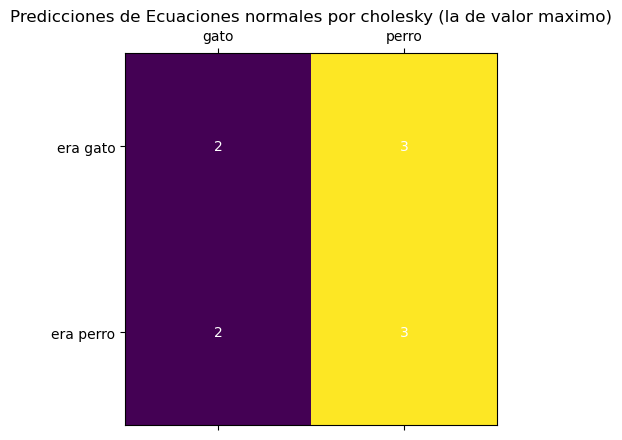

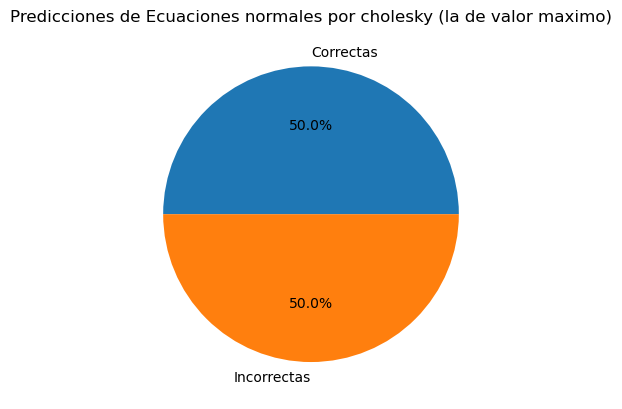

In [143]:
graficar_predicciones_de_metodo("Ecuaciones normales por cholesky", YvProbabilidadesEqNorm, Yv)

recordar que pinvecuacionesnormales tiene 3 for y uno vectorizado, pinvsvd tiene 4 y uno vectorizado (aunque hay uno que hace multiplicaciones cada vez mas chicas, seria 2.5), HH hace 5 for y uno vectorizado, y gr hace 2 y uno vectorizado.
capaz es mejor decir que hay algunos con muchas mas multiplicaciones de matrices.